### In this project, along with drawing basic conclusions from the database, I will perform two main actions:
1) I will create a special index that calculates the value of each computer model in relation to its price, based on public opinion. This index will return values ​​in the range 0-1, where the value 1 represents a high return relative to the price while the value 0 represents zero return relative to the price. With the help of this index, more general calculations can be made for the brands themselves, beyond the models. 
2) I will estimate a polynomial regression using the OLS method, which will aim to represent the relationship between the users' satisfaction with a computer model and its price.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_data = pd.read_csv("C:/Users/user/Desktop/Data_analyst_course/Projects_Datasets/best_buy_laptops_2024.csv")

In [3]:
raw_data.head()

,brand,model,Average_Rate,Number_of_Reviews,offers/price,offers/priceCurrency,depth,width,features/0/description,features/1/description
0,Dell,i7430-7374SLV-PUS,4.7,1088.0,NaN,USD,8.92,12.36,Windows 11 brings back the Start Menu from Win...,"Equipped with a FHD+ IPS touch screen, the bor..."
1,Dell,i3520-5810BLK-PUS,4.6,839.0,NaN,USD,9.27,14.11,Experience the most secure Windows ever built ...,Natural finger-touch navigation makes the most...
2,Lenovo,82YL0002US,4.7,127.0,NaN,USD,8.76,12.51,Windows 11 brings back the Start Menu from Win...,Find the relevant information and ideas you ne...
3,Microsoft,DTI-00001,4.7,926.0,NaN,USD,7.90,11.50,Find the relevant information and ideas you ne...,Iconic 2-in-1 design transforms into what you ...
4,Microsoft,R1S-00062,4.7,422.0,NaN,USD,8.80,12.10,Find the relevant information and ideas you ne...,"Family, friends, passions, music, creations – ..."


In [4]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Average_Rate,357.0,4.413445,0.641880,1.00,4.200,4.60,4.80,5.00
Number_of_Reviews,357.0,254.708683,607.260976,1.00,3.000,18.00,208.00,4231.00
offers/price,262.0,1159.040687,782.605079,143.99,639.990,959.99,1494.99,4489.99
depth,431.0,9.678770,2.911987,0.49,8.655,9.22,10.40,20.25
width,431.0,11.927030,3.333199,0.58,11.300,12.51,14.05,18.10


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   brand                   489 non-null    object 
 1   model                   488 non-null    object 
 2   Average_Rate            357 non-null    float64
 3   Number_of_Reviews       357 non-null    float64
 4   offers/price            262 non-null    float64
 5   offers/priceCurrency    489 non-null    object 
 6   depth                   431 non-null    float64
 7   width                   431 non-null    float64
 8   features/0/description  486 non-null    object 
 9   features/1/description  483 non-null    object 
dtypes: float64(5), object(5)
memory usage: 38.3+ KB


In [6]:
raw_data.isna().sum()

brand                       0
model                       1
Average_Rate              132
Number_of_Reviews         132
offers/price              227
offers/priceCurrency        0
depth                      58
width                      58
features/0/description      3
features/1/description      6
dtype: int64

In [7]:
(raw_data['offers/priceCurrency'] != 'USD').sum()

0

In [8]:
raw_data = raw_data.drop(columns='offers/priceCurrency')

# Brands Analysis

## Average Brand Rate

In [9]:
# Crating a new df withouth models have less than 10 reviews:
brands_data = raw_data[raw_data['Number_of_Reviews'] > 10]
brands_data.size

1809

In [10]:
brands = brands_data.groupby('brand')

In [11]:
avg_brand_rate = pd.DataFrame(brands['Average_Rate'].mean().sort_values(ascending=False).reset_index()) # Calculating the average rate for each brand
print('The average rate for each brand is:')
print()
avg_brand_rate

The average rate for each brand is:



,brand,Average_Rate
0,Microsoft,4.706061
1,Samsung,4.662500
2,HP OMEN,4.625000
3,LG,4.550000
4,Dell,4.520833
5,Acer,4.487500
6,Lenovo,4.470588
7,HP,4.452632
8,MSI,4.428571
9,ASUS,4.412500


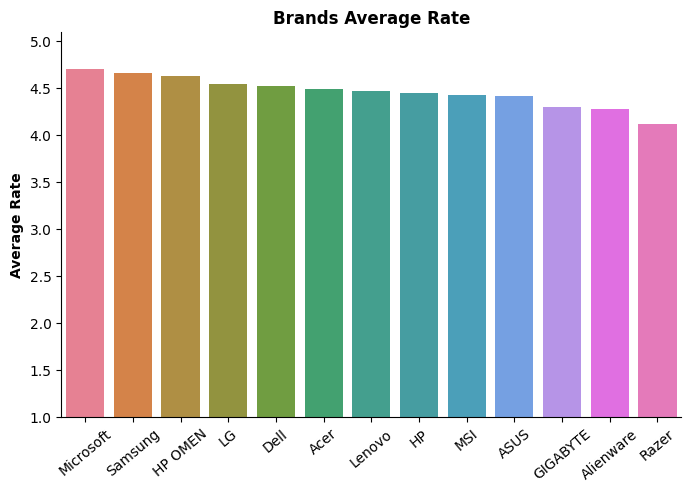

In [12]:
plt.figure(figsize=(8,5))
sns.barplot(data=avg_brand_rate,
            x='brand',
            y='Average_Rate',
           hue='brand')
plt.xticks(rotation=40)
plt.yticks(np.arange(1,6,0.5))
plt.ylim(1,5.1)
plt.xlabel(None)
plt.ylabel('Average Rate',
          weight='bold')

plt.title('Brands Average Rate',
         weight='bold')
sns.despine()
plt.show()

# Value for money calculator

 At this stage I will build an index that represents for each model the value in relation to the price. The construction of the index will be done in the following steps:
1) Calculation of the value for money ratio (rating / price).
2) Reconversion of the return ratio to a scale in the range 0 to 1.

In [13]:
# Creating a new df to work with:

money_values_data = brands_data.copy()

In [14]:
# Calculating the Average Rate of each brand:

brand_avg_rate = brands['Average_Rate'].transform('mean')
print('N-Unique values:', brand_avg_rate.nunique())
brand_avg_rate

N-Unique values: 13


0      4.520833
1      4.520833
2      4.470588
3      4.706061
4      4.706061
         ...   
429    4.452632
437    4.520833
451    4.412500
459    4.452632
476    4.470588
Name: Average_Rate, Length: 201, dtype: float64

In [15]:
# Filling the missing values with 'brand_avg':
money_values_data.loc[:, 'Average_Rate'] = money_values_data.loc[:, 'Average_Rate'].fillna(brand_avg_rate)
print('Missing values:')
money_values_data['Average_Rate'].isna().sum()

Missing values:


0

In [16]:
# Calculating the average price of each brand:

## as we can see here, some of the brands have no price data at all. for that reason I have no option to drop them out of the dataframe
## and focus only on the exsicting data. 


print(brands['offers/price'].mean())

brand
ASUS         1230.990000
Acer         1365.990000
Alienware            NaN
Dell          358.590000
GIGABYTE             NaN
HP            321.597500
HP OMEN              NaN
LG                   NaN
Lenovo        403.156667
MSI          1274.990000
Microsoft    1249.990000
Razer                NaN
Samsung              NaN
Name: offers/price, dtype: float64


In [17]:
brand_avg_price = brands['offers/price'].transform('mean')
money_values_data['offers/price'] = money_values_data['offers/price'].fillna(brand_avg_price)

print('Missing values in "offer/price" after filling:')
money_values_data['offers/price'].isna().sum()

Missing values in "offer/price" after filling:


25

In [18]:
# Filling the missing values with 'brand_avg_price':

money_values_data = money_values_data.dropna(subset='offers/price')
money_values_data = money_values_data[['brand', 'model', 'Average_Rate', 'offers/price']]
money_values_data

,brand,model,Average_Rate,offers/price
0,Dell,i7430-7374SLV-PUS,4.7,358.590000
1,Dell,i3520-5810BLK-PUS,4.6,358.590000
2,Lenovo,82YL0002US,4.7,403.156667
3,Microsoft,DTI-00001,4.7,1249.990000
4,Microsoft,R1S-00062,4.7,1249.990000
...,...,...,...,...
429,HP,14-dq0001dx,4.4,212.990000
437,Dell,5490,4.3,396.990000
451,ASUS,GZ301VU-DS94,4.6,1230.990000
459,HP,14-DQ0080NR,3.4,321.597500


In [19]:
# Calculating for each row the scaled Rate/Price ratio, when higher ratio means higher value for money:

rate_price_ratio = money_values_data['Average_Rate'] / money_values_data['offers/price']
money_values_data['RP_Ratio'] = rate_price_ratio
money_values_data.head()

,brand,model,Average_Rate,offers/price,RP_Ratio
0,Dell,i7430-7374SLV-PUS,4.7,358.590000,0.013107
1,Dell,i3520-5810BLK-PUS,4.6,358.590000,0.012828
2,Lenovo,82YL0002US,4.7,403.156667,0.011658
3,Microsoft,DTI-00001,4.7,1249.990000,0.003760
4,Microsoft,R1S-00062,4.7,1249.990000,0.003760


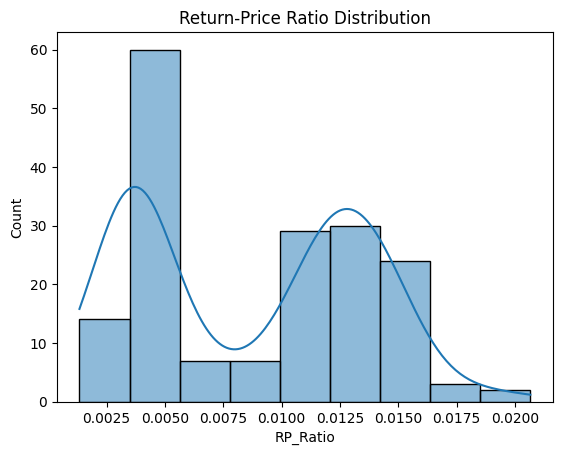

In [20]:
# Checking the RP ratio distribution:

sns.histplot(money_values_data['RP_Ratio'],
           kde=True)
plt.title('Return-Price Ratio Distribution')
plt.show()

In [21]:
# scaling the results:

from sklearn.preprocessing import MinMaxScaler
value_scaler = MinMaxScaler()

In [22]:
rp_to_rescale = np.array(money_values_data['RP_Ratio']).reshape(-1,1)
rp_to_rescale[:5]

array([[0.01310689],
       [0.01282802],
       [0.011658  ],
       [0.00376003],
       [0.00376003]])

In [23]:
scaled_RP = value_scaler.fit_transform(rp_to_rescale)
print('scaled RP min:', scaled_RP.min())
print('scaled RP max:', scaled_RP.max())
print('scaled RP quantiles:', np.quantile(scaled_RP,
                                           [0.25, 0.5, 0.75]))

scaled RP min: 0.0
scaled RP max: 1.0
scaled RP quantiles: [0.12557328 0.45725473 0.59481175]


In [24]:
money_values_data['RP_value'] = scaled_RP

In [25]:
money_values_data

,brand,model,Average_Rate,offers/price,RP_Ratio,RP_value
0,Dell,i7430-7374SLV-PUS,4.7,358.590000,0.013107,0.609242
1,Dell,i3520-5810BLK-PUS,4.6,358.590000,0.012828,0.594812
2,Lenovo,82YL0002US,4.7,403.156667,0.011658,0.534267
3,Microsoft,DTI-00001,4.7,1249.990000,0.003760,0.125573
4,Microsoft,R1S-00062,4.7,1249.990000,0.003760,0.125573
...,...,...,...,...,...,...
429,HP,14-dq0001dx,4.4,212.990000,0.020658,1.000000
437,Dell,5490,4.3,396.990000,0.010832,0.491499
451,ASUS,GZ301VU-DS94,4.6,1230.990000,0.003737,0.124373
459,HP,14-DQ0080NR,3.4,321.597500,0.010572,0.478082


In [26]:
RP_brand_groups = money_values_data.groupby('brand')

In [27]:
avg_brand_RPV = pd.DataFrame(RP_brand_groups['RP_value'].mean())
avg_brand_RPV = avg_brand_RPV.reset_index()
avg_brand_RPV = avg_brand_RPV.sort_values(by='RP_value',
                          ascending=False)
avg_brand_RPV

,brand,RP_value
3,HP,0.659081
2,Dell,0.595568
4,Lenovo,0.517939
1,Acer,0.162756
5,MSI,0.161703
6,Microsoft,0.127841
0,ASUS,0.119629


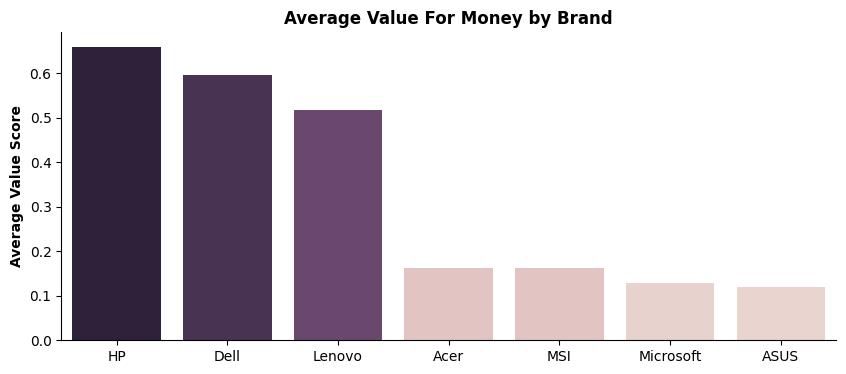

In [28]:
# Plottong results:

plt.figure(figsize=(10,4))
sns.barplot(data = avg_brand_RPV,
            x='brand',
            y='RP_value',
            hue='RP_value',
           legend=False)

plt.xlabel(None)
plt.ylabel('Average Value Score',
          weight='bold')
plt.title('Average Value For Money by Brand',
         weight='bold')

sns.despine()
plt.show()

In [29]:
# Performing the most Valued models:

top_40_valued_models = money_values_data.sort_values('RP_value', ascending=False)[:40]
top_40_valued_models

,brand,model,Average_Rate,offers/price,RP_Ratio,RP_value
429,HP,14-dq0001dx,4.4,212.9900,0.020658,1.000000
340,Dell,NaN,3.3,172.9900,0.019076,0.918137
254,Lenovo,T470.i5.8.256.Pro,3.9,215.9900,0.018056,0.865363
291,Lenovo,T480.8.256.Pro,4.7,263.9900,0.017804,0.852287
85,HP,840G3.8.256.Pro,3.8,226.9900,0.016741,0.797286
102,HP,15-fe0053dx,4.8,321.5975,0.014925,0.703349
16,HP,17-cw0023dx,4.8,321.5975,0.014925,0.703349
423,HP,840 G3-31676,4.4,298.8500,0.014723,0.692876
158,HP,15-fb1013dx,4.7,321.5975,0.014615,0.687258
17,HP,14-es0013dx,4.7,321.5975,0.014615,0.687258


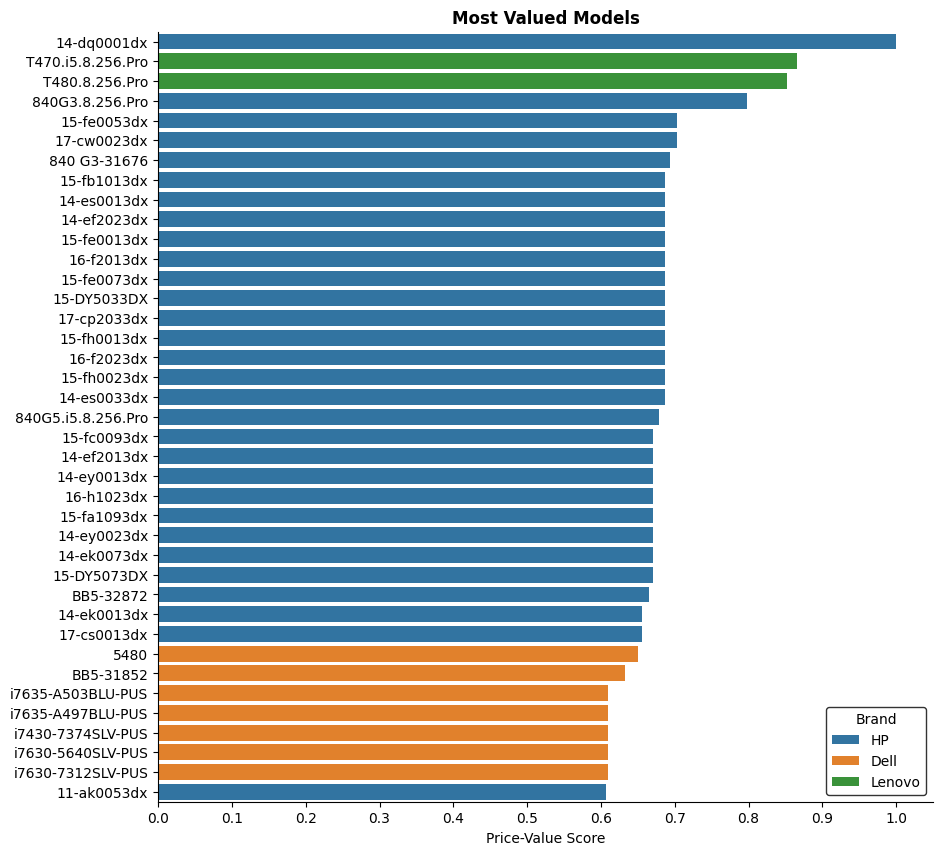

In [30]:
# Plotting the most valued models:

plt.figure(figsize=(10,10))
sns.barplot(data=top_40_valued_models,
            y='model',
            x='RP_value',
            hue='brand',
           )
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel(None)
plt.xlabel('Price-Value Score')

plt.legend(title='Brand',
          edgecolor='k')
plt.title('Most Valued Models',
         weight='bold')
sns.despine()
plt.show()

In [31]:
money_values_data.head()

,brand,model,Average_Rate,offers/price,RP_Ratio,RP_value
0,Dell,i7430-7374SLV-PUS,4.7,358.590000,0.013107,0.609242
1,Dell,i3520-5810BLK-PUS,4.6,358.590000,0.012828,0.594812
2,Lenovo,82YL0002US,4.7,403.156667,0.011658,0.534267
3,Microsoft,DTI-00001,4.7,1249.990000,0.003760,0.125573
4,Microsoft,R1S-00062,4.7,1249.990000,0.003760,0.125573


In [32]:
money_value_groups = money_values_data.groupby('brand')
print('N groups:', money_values_data['brand'].nunique())
groups_names = money_values_data['brand'].unique()
print('Groups names:', groups_names)

N groups: 7
Groups names: ['Dell' 'Lenovo' 'Microsoft' 'ASUS' 'HP' 'Acer' 'MSI']


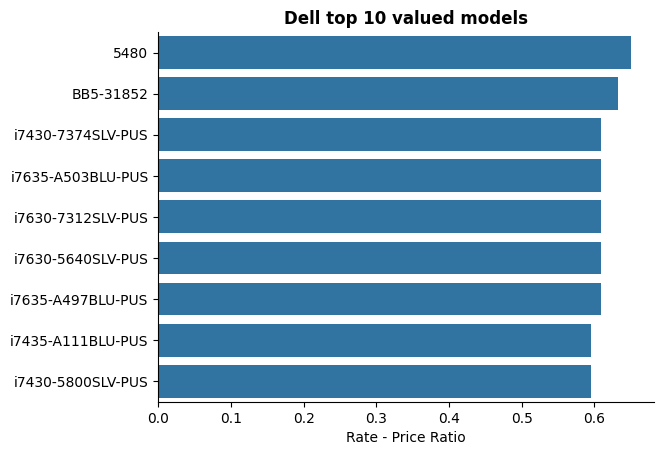

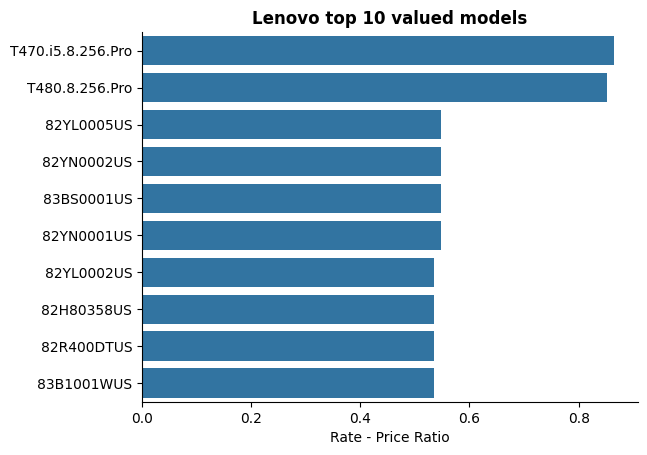

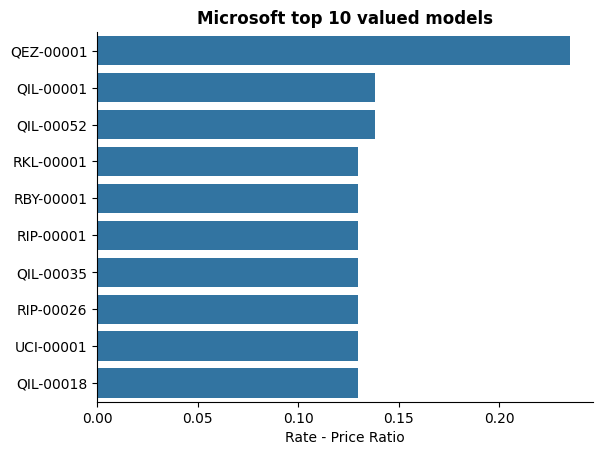

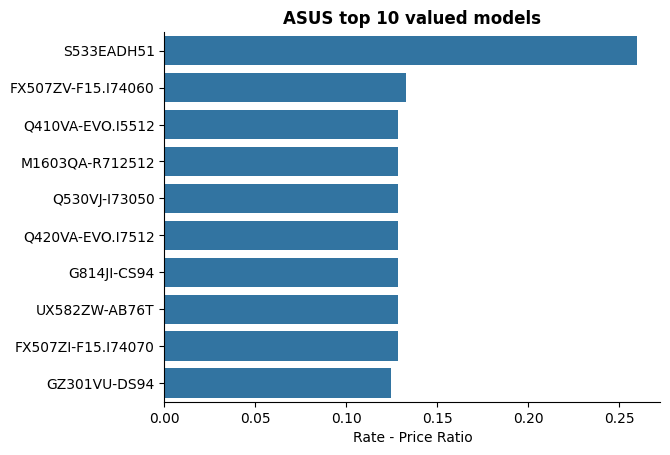

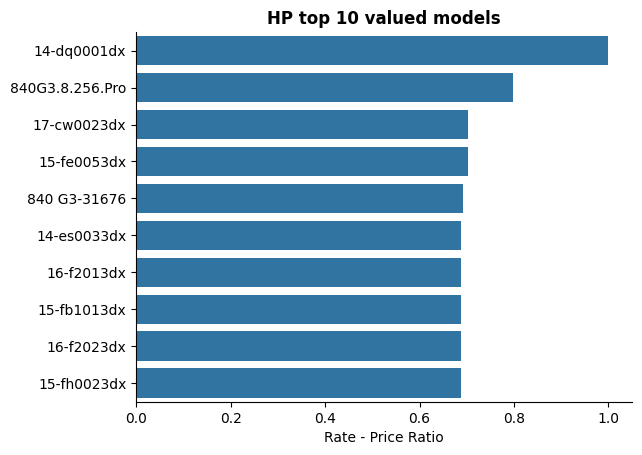

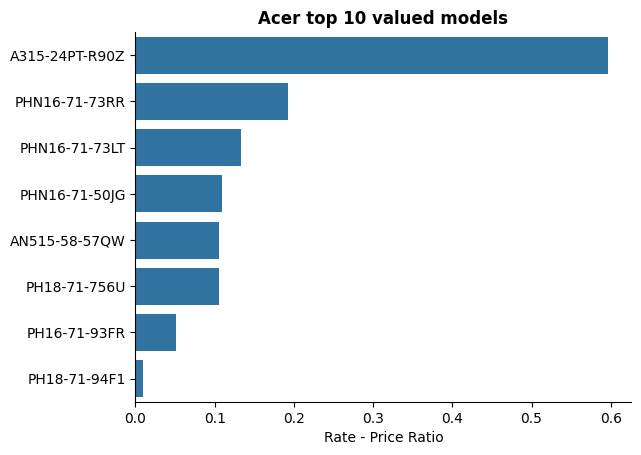

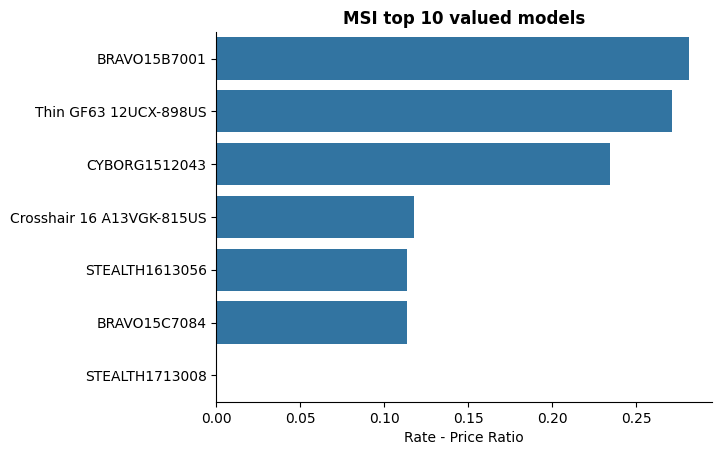

In [33]:
# For each brand, calculating and plotting the most valued models:

for brand in groups_names:
    g = money_value_groups.get_group(brand)
    g = g.sort_values(by='RP_value', ascending=False)[:10]
    plt.figure()
    sns.barplot(data=g,
    y='model',
    x='RP_value')
    plt.xlabel('Rate - Price Ratio')
    plt.ylabel(None)
    plt.title(f'{brand} top 10 valued models', weight='bold')
    sns.despine()

In [34]:
money_value_groups.get_group('Dell')

,brand,model,Average_Rate,offers/price,RP_Ratio,RP_value
0,Dell,i7430-7374SLV-PUS,4.7,358.59,0.013107,0.609242
1,Dell,i3520-5810BLK-PUS,4.6,358.59,0.012828,0.594812
5,Dell,i7630-7312SLV-PUS,4.7,358.59,0.013107,0.609242
20,Dell,i3420-S476SLV-PUS,4.3,358.59,0.011991,0.551520
25,Dell,XPS9530-7718SLV-PUS,4.5,358.59,0.012549,0.580381
37,Dell,XPS9315-7725SKY-PUS,4.4,358.59,0.012270,0.565951
39,Dell,i7630-5640SLV-PUS,4.7,358.59,0.013107,0.609242
46,Dell,i7435-A111BLU-PUS,4.6,358.59,0.012828,0.594812
68,Dell,i7430-5800SLV-PUS,4.6,358.59,0.012828,0.594812
88,Dell,i3535-A766BLK-PUS,4.5,358.59,0.012549,0.580381


# Explaining the rate by price, by using a polynomial OLS regression

In [35]:
data_to_scatter = raw_data.copy()
data_to_scatter = data_to_scatter[['Average_Rate', 'offers/price']]
data_to_scatter = data_to_scatter.dropna()
data_to_scatter

,Average_Rate,offers/price
13,4.6,1179.99
23,4.8,1199.99
31,4.8,1199.99
45,4.4,3299.99
53,5.0,339.99
...,...,...
476,3.7,458.99
479,3.3,431.99
484,5.0,365.99
485,5.0,1449.99


In [36]:
avg_rate = data_to_scatter['Average_Rate']
price = data_to_scatter['offers/price']

# Creating Polunomial Regression (degree 3)
reg = np.polyfit(price, avg_rate, deg=3)

# Creating a polynomial function
p = np.poly1d(reg)

# Creating new values to plot the regression
x = np.linspace(min(price), max(price), 100)
y = p(x)

reg

array([ 2.70293806e-12, -2.98258496e-07,  8.15119960e-04,  3.87302643e+00])

y = 2.70e-12x^3 + -2.98e-07x^2 + 8.15e-04x + 3.87



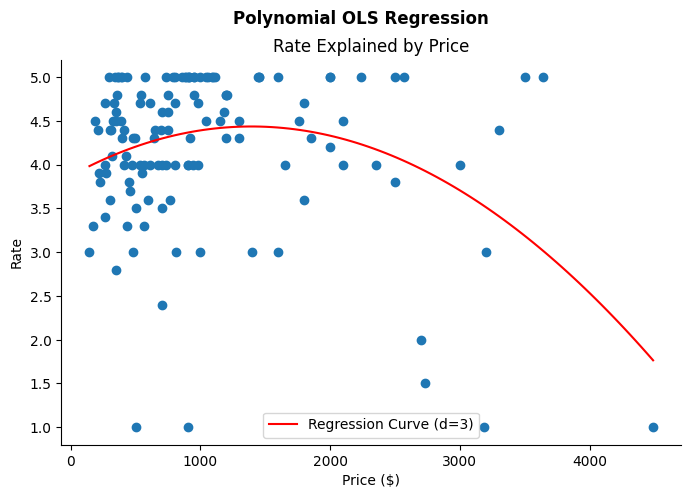

In [37]:
plt.figure(figsize=(8,5))
plt.scatter(price, avg_rate)
plt.plot(x, y, label='Regression Curve (d=3)', color='red')

plt.suptitle('Polynomial OLS Regression', weight='bold')
plt.xlabel('Price ($)')
plt.ylabel('Rate')
plt.title('Rate Explained by Price')
plt.legend()

print(f"y = {reg[0]:.2e}x^3 + {reg[1]:.2e}x^2 + {reg[2]:.2e}x + {reg[3]:.2f}")
print() 

sns.despine()
plt.show()